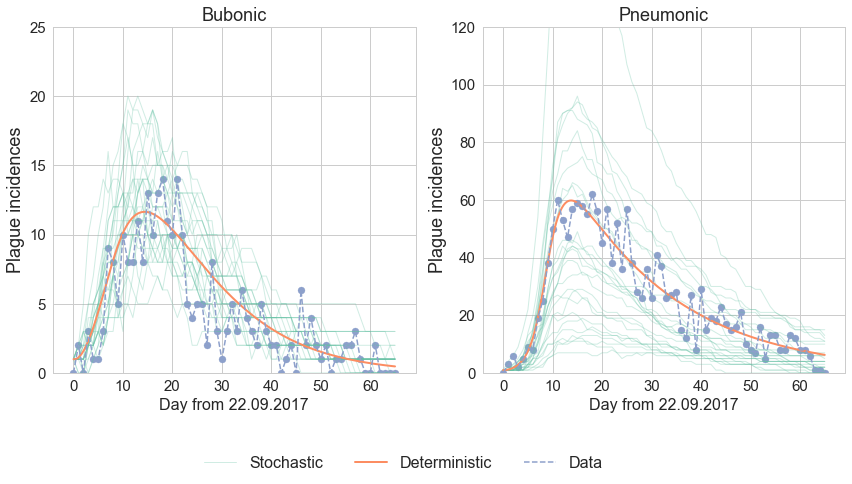

In [7]:
%matplotlib inline
# coding: utf-8
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')
sns.set(palette='Set2')
plt.style.use('seaborn-whitegrid')
# plt.rc('font', family='Myriad Pro')
plt.rc('text', usetex=False)
ncolours = len(plt.rcParams['axes.prop_cycle'])
colours = [list(plt.rcParams['axes.prop_cycle'])[i]['color'] for i in range(ncolours)]

# General functions

def unit_vector(i, D):
    '''Returns (i+1)-th unit vector of dimension D'''
    
    out = np.zeros(D)
    out[i] = 1
    return out


def get_time(rates, Pk, Tk):
    '''Time step and index of reaction'''
    
    n = len(rates)
    dt = np.array([((Pk[i] - Tk[i])/rates[i]) if rates[i]>0.0 else np.inf for i in range(n)])
    idx = np.argmin(dt)
    
    return idx, dt[idx]


# Parameters

# Fitted to new data and # old data
#          eps          tau        bBite         bAir           iB           iP            p           cB 
# 8.679882e-05 7.792622e+00 1.236645e-03 1.136276e+00 1.234682e-01 4.508904e-01 5.932061e-03 7.787123e-02 
#           cP 
# 4.701696e-02 
alpha   = 1.236645e-03 # 2.735812e-06 # rate of bites
beta    = 1.136276e+00 # 1.293875e+00 # between-host infection
gamma_b = 1.234682e-01 # 1.162012e-01 # E to I
gamma_p = 4.508904e-01 # 3.988684e-01 # E to I
delta_b = 7.787123e-02 # 1.202085e-01 # recovery + death
delta_p = 4.701696e-02 # 7.207759e-02 # recovery + death
epsilon = 5.932061e-03 # 2.854848e-03 # I_b to I_p
p       = 8.679882e-05 # 4.222274e-01 # fraction susceptible to bite

N       = 25570895 # population size

# Initial condition
S_b_0 = int(N*p)
S_p_0 = N - S_b_0

D = 6 # number of variables in the system

A = 1.15
B = 0.08
C = 0.1

k   = 1.
tau = 7.792622e+00 # 7.993448e+00 # old data

def flea(t):
    return A + B*np.sin((np.pi/180.)*t) + C*np.cos((np.pi/180.)*t)
    
def intervention(t):
    return 1. - 1./(1. + np.exp(-k*(t - tau)))

v_flea = np.vectorize(flea)
v_itv = np.vectorize(intervention)

# Problem-dependent functions

def transition_rates(x, f_irf, f_itv):
    '''Transition rates for every possible reaction'''
    return np.array([alpha*f_irf*f_itv*x[0], beta*f_itv*x[0]*x[5]/N, beta*f_itv*x[1]*x[5]/N, 
                     gamma_b*x[2], gamma_p*x[3], delta_b*x[4], delta_p*x[5], epsilon*x[4]])
            

# Stoichiometric vectors
# nu[i] corresponds to the i-th reaction
nu = np.array([unit_vector(2, D) - unit_vector(0, D), unit_vector(3, D) - unit_vector(0, D),
               unit_vector(3, D) - unit_vector(1, D), unit_vector(4, D) - unit_vector(2, D),
               unit_vector(5, D) - unit_vector(3, D), -unit_vector(4, D), -unit_vector(5, D),
               unit_vector(5, D) - unit_vector(4, D)], dtype=int)

# Solution for constant rates (f_irf and f_itv are scalars)

def plague(x):
    t = 0.0
    times = [t]
    x_t = [x]
    rates = transition_rates(x, f_irf, f_itv)
    n = len(rates)
    Pk = np.array([-np.log(np.random.random()) for _ in range(n)])
    Tk = np.zeros(n)
    while (x[0] + x[1]) > 0:
        reaction, time = get_time(rates, Pk, Tk)
        
        if time == np.inf:
            break
        
        t += time
        x = x + nu[reaction]
        x_t.append(x)
        times.append(t)
        Tk = np.array([Tk[k] + rates[k]*time for k in range(n)])
        Pk[reaction] -= np.log(np.random.random())
        rates = transition_rates(x)
        
    times = np.array(times)
    x_t = np.array(x_t)
    
    return times, x_t


# Solution for time-dependent rates (f_irf and f_itv are arrays of the same length as t)
# Naive tau-leaping

def plague_tau(x, t, dt, f_irf, f_itv):
    x_t = []
    for i in range(len(t)):
        x_t.append(x)
        rates = transition_rates(x, f_irf[i], f_itv[i])
        n = len(rates)
        firings = np.random.poisson(np.maximum(rates, np.zeros(n))*dt)
        change = np.sum([firings[i]*nu[i] for i in range(len(rates))], axis=0)
        x = x + change
        
    x_t = np.array(x_t)
    
    return x_t

# Deterministic solution

def det(x, t):
    return [- alpha*flea(t)*intervention(t)*x[0] - beta*intervention(t)*x[0]*x[5]/N, -beta*intervention(t)*x[1]*x[5]/N,  
            alpha*flea(t)*intervention(t)*x[0] - gamma_b*x[2], beta*intervention(t)*(x[0]+x[1])*x[5]/N - gamma_p*x[3],
            gamma_b*x[2] - epsilon*x[4] - delta_b*x[4], gamma_p*x[3] + epsilon*x[4] - delta_p*x[5]]


x_0 = [S_b_0, S_p_0, 0, 0, 1, 1]
dt = 0.1
t = np.arange(0., 65. + dt, dt)
f_irf = v_flea(t)
f_itv = v_itv(t)

z = odeint(det, x_0, t)

runs = 25

I_b = []
I_p = []

for realisation in range(runs):
    y = plague_tau(x_0, t, dt, f_irf, f_itv)
    I_b.append(y[:, 4][: : int(1./dt)])
    I_p.append(y[:, 5][: : int(1./dt)])


# Data

data_raw = pd.read_csv('~/dataBy.csv', sep=';')
data_raw['date'] = pd.to_datetime(data_raw['date'])
start_date = data_raw[data_raw['date'] == pd.to_datetime('22/09/2017')].index[0]
data_raw = data_raw[start_date:]
data_b = np.array(data_raw['bubonic'])
data_p = np.array(data_raw['pneumonic'])

fig, axes = plt.subplots(1,2, figsize=(12,6))

axes[0].plot(t[: : int(1./dt)], I_b[0], linewidth=1., color=colours[0], alpha=0.3, label='Stochastic')
axes[1].plot(t[: : int(1./dt)], I_p[0], linewidth=1., color=colours[0], alpha=0.3)

for i in range(1,runs):
    axes[0].plot(t[: : int(1./dt)], I_b[i], linewidth=1., color=colours[0], alpha=0.3)
    axes[1].plot(t[: : int(1./dt)], I_p[i], linewidth=1., color=colours[0], alpha=0.3)

axes[0].set_ylim(0,25)
axes[1].set_ylim(0,120)

axes[0].set_yticks([0,5,10,15,20,25])

axes[0].plot(t, z[:,4], color=colours[1], linestyle='-', linewidth=2., label='Deterministic')
axes[1].plot(t, z[:,5], color=colours[1], linestyle='-', linewidth=2.)

axes[0].scatter(t[: : int(1./dt)], data_b, color=colours[2])
axes[1].scatter(t[: : int(1./dt)], data_p, color=colours[2])

axes[0].plot(t[: : int(1./dt)], data_b, color=colours[2], linestyle='--', linewidth=1.5, label='Data')
axes[1].plot(t[: : int(1./dt)], data_p, color=colours[2], linestyle='--', linewidth=1.5)

axes[0].tick_params(labelsize=15)
axes[1].tick_params(labelsize=15)

axes[0].set_ylabel('Plague incidences', fontsize=18)
axes[1].set_ylabel('Plague incidences', fontsize=18)
axes[1].set_xlabel('Day from 22.09.2017', fontsize=16)
axes[0].set_xlabel('Day from 22.09.2017', fontsize=16)

axes[0].set_title('Bubonic', fontsize=18)
axes[1].set_title('Pneumonic', fontsize=18)

axes[0].legend(loc=(0.4,-0.3), ncol=3, fontsize=16)

plt.tight_layout()
plt.savefig('/Users/macbookair/Dropbox/incidences.pdf', dpi=300, bbox_inches='tight')
